# Import

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import pickle

import plotly.io as pio

In [2]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [3]:
df = pd.concat([pd.read_csv('../Data/Body_Results.csv'),
            pd.read_csv('../Data/chicken_inter_final.csv'), # chickenpox cubic + nearest mrate 0.8 에서
            pd.read_csv('../Data/R_GNAR_results.csv'), # GNAR을 R에서 돌린 결과 RANDOM, BLOCK
            pd.concat([pd.read_csv('../Data/DCRNN_50_windmillsmall.csv'), # 50% windmillsmall 결과들
                       pd.read_csv('../Data/GConvGRU_50_windmillsmall.csv'),
                       pd.read_csv('../Data/GConvLSTM_50_windmillsmall.csv'),
                       pd.read_csv('../Data/LRGCN_50_windmillsmall.csv'),
                       pd.read_csv('../Data/DyGrEncoder_50_windmillsmall.csv'),
                       pd.read_csv('../Data/TGCN_50_windmillsmall.csv'),
                       pd.read_csv('../Data/GCLSTM_50_windmillsmall.csv'),
                       pd.read_csv('../Data/EvolveGCNO_50_windmillsmall.csv'),
                       pd.read_csv('../Data/EvolveGCNH_50_windmillsmall.csv'),
                      ]),
            pd.concat([pd.read_csv('../Data/DCRNN_80_windmillsmall.csv'), # 80% windmillsmall 결과들
                       pd.read_csv('../Data/LRGCN_80_windmillsmall.csv'),
                       pd.read_csv('../Data/DyGrEncoder_80_windmillsmall.csv'),
                       pd.read_csv('../Data/GConvLSTM_80_windmillsmall.csv'),
                       pd.read_csv('../Data/GConvGRU_80_windmillsmall.csv'),
                       pd.read_csv('../Data/TGCN_80_windmillsmall.csv'),
                       pd.read_csv('../Data/GCLSTM_80_windmillsmall.csv'),
                       pd.read_csv('../Data/EvolveGCNO_80_windmillsmall.csv'),
                       pd.read_csv('../Data/EvolveGCNH_80_windmillsmall.csv')
                      ]),
            pd.concat([pd.read_csv('../Data/DCRNN_block_windmillsmall.csv'), # block windmillsmall 결과물
                      pd.read_csv('../Data/LRGCN_block_windmillsmall.csv'),
                      pd.read_csv('../Data/GConvGRU_block_windmillsmall.csv'),
                      pd.read_csv('../Data/EvolveGCNO_block_windmillsmall.csv'),
                      pd.read_csv('../Data/DyGrEncoder_block_windmillsmall.csv'),
                      pd.read_csv('../Data/GConvLSTM_block_windmillsmall.csv'),
                      pd.read_csv('../Data/GCLSTM_block_windmillsmall.csv'),
                      pd.read_csv('../Data/TGCN_block_windmillsmall.csv'),
                      pd.read_csv('../Data/EvolveGCNH_block_windmillsmall.csv')
                      ])
               ]).assign(model = lambda df: df.model.apply(lambda x: 'GConvGRU' if x == "GComvGRU" else x))
df = df.iloc[:,:-1]

# Conditions

| Model               | FiveVTS | Chickenpox | Pedalme | Wikimath | Windmillsmall | MontevideoBus |
|---------------------|---------|------------|---------|----------|---------------|---------------|
| Max iter.           | 30      | 30         | 30      | 30       | 30            | 30            |
| Epochs              | 50      | 50         | 50      | 50       | 50            | 50            |
| Lags                | 2       | 4          | 4       | 8        | 8             | 4             |
| Interpolation       | linear  | linear,nearest,cubic     | linear  | linear   | linear        | linear       |
| Filters             |         |            |         |          |               |               |
| GConvGRU            | 12      | 16         | 12      | 12       | 12            | 12            |
| GConvLSTM           | 12      | 32         | 2       | 64       | 16            | 12            |
| GCLSTM              | 4       | 16         | 4       | 64       | 16            | 12            |
| LRGCN               | 4       | 8          | 8       | 32       | 12            | 2             |
| DyGrEncoder         | 12      | 12         | 12      | 12       | 12            | 12            |
| EvolveGCNH          | No need | No need    | No need | No need  | No need       | No need       |
| EvolveGCNO          | No need | No need    | No need | No need  | No need       | No need       |
| TGCN                | 12      | 12         | 12      | 12       | 12            | 8             |
| DCRNN               | 2       | 16         | 8       | 12       | 4             | 12            |


# Data & 사용자정의함수

In [4]:
df_dataset = pd.DataFrame({
    'dataset':['fivenodes','chickenpox','pedalme','wikimath','windmillsmall','monte'],
    'node':[5,20,15,1068,11,675],
    'time':[200,522,36,731,17472,744]
})
df = df\
.merge(df_dataset)\
.assign(method = lambda df: df['method'].map({'STGCN':'STGNN','IT-STGCN':'IT-STGNN','GNAR':'GNAR'}))

In [5]:
df.head()

,dataset,method,mrate,mtype,lags,nof_filters,inter_method,epoch,mse,calculation_time,model,node,time
0,fivenodes,STGNN,0.0,NaN,2,12.0,NaN,50.0,0.729374,80.985221,GConvGRU,5,200
1,fivenodes,STGNN,0.0,NaN,2,12.0,NaN,50.0,0.729082,80.891788,GConvGRU,5,200
2,fivenodes,IT-STGNN,0.0,NaN,2,12.0,NaN,50.0,0.731600,114.492592,GConvGRU,5,200
3,fivenodes,IT-STGNN,0.0,NaN,2,12.0,NaN,50.0,0.735026,115.544274,GConvGRU,5,200
4,fivenodes,STGNN,0.0,NaN,2,12.0,NaN,50.0,0.727182,102.783140,GConvGRU,5,200


In [6]:
# df2 = pd.read_csv('../Data/Appendix_Results.csv').iloc[:,1:]

In [7]:
# df.assign(model = lambda df: df.model.apply(lambda x: '' if x == "GNAR" else x))\
# .eval('model = method+model')

In [8]:
# df2 = df.assign(model = lambda df: df.model.apply(lambda x: '' if x == "GNAR" else x))\
# .eval('model = method+model')\
# .assign(model = lambda df: df.model.str.replace("STGNN",""))
# df2.head()

In [9]:
set(df.method)

{'IT-STGNN', 'STGNN'}

In [10]:
df2 = df.assign(model = lambda df: df.model.apply(lambda x: '' if x == "GNAR" else x))

In [11]:
def show_experiment_spec(df):
    df_cols = ['method','mrate','mtype','lags','nof_filters','inter_method','epoch','model']
    for dataset in df.dataset.unique():
        print(f'dataset: {dataset}')
        for col in df_cols: 
            df_query = df[df['dataset'] == dataset]
            print(f'{col}: {df_query[col].unique().tolist()}')
        print('---')

`-` 데이터세트별 실험셋팅 

In [12]:
show_experiment_spec(df)

dataset: fivenodes
method: ['STGNN', 'IT-STGNN']
mrate: [0.0, 0.7, 0.8, 0.3, 0.5, 0.6, 0.125]
mtype: [nan, 'rand', 'block']
lags: [2]
nof_filters: [12.0, 4.0, 2.0]
inter_method: [nan, 'linear']
epoch: [50.0]
model: ['GConvGRU', 'GConvLSTM', 'GCLSTM', 'DCRNN', 'LRGCN', 'TGCN', 'EvolveGCNO', 'DyGrEncoder', 'EvolveGCNH']
---
dataset: chickenpox
method: ['STGNN', 'IT-STGNN']
mrate: [0.0, 0.3, 0.8, 0.5, 0.6, 0.2877697841726618]
mtype: [nan, 'rand', 'block']
lags: [4]
nof_filters: [16.0, 32.0, 8.0, 12.0]
inter_method: [nan, 'linear', 'cubic', 'nearest']
epoch: [50.0]
model: ['GConvGRU', 'GConvLSTM', 'GCLSTM', 'DCRNN', 'LRGCN', 'TGCN', 'EvolveGCNO', 'DyGrEncoder', 'EvolveGCNH']
---
dataset: pedalme
method: ['STGNN', 'IT-STGNN']
mrate: [0.0, 0.3, 0.5, 0.6, 0.8, 0.2857142857142857]
mtype: [nan, 'rand', 'block']
lags: [4]
nof_filters: [12.0, 2.0, 4.0, 8.0]
inter_method: [nan, 'linear']
epoch: [50.0]
model: ['GConvGRU', 'GConvLSTM', 'GCLSTM', 'DCRNN', 'LRGCN', 'TGCN', 'EvolveGCNO', 'DyGrEncoder',

`-` 요약 

In [13]:
df_summary = df2.groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()\
.pivot_table(index=['model'],columns=['dataset'],values='mse')
df_summary

dataset,chickenpox,fivenodes,monte,pedalme,wikimath,windmillsmall
model,,,,,,
DCRNN,1.186396,1.245254,1.040303,1.315441,0.634883,1.100661
DyGrEncoder,1.230307,1.268549,1.189316,1.313140,0.618263,1.171635
EvolveGCNH,1.068355,1.191876,1.634331,1.256039,0.817415,1.102485
EvolveGCNO,1.079361,1.181221,1.818289,1.270238,0.763434,1.137759
GCLSTM,1.226473,1.229599,1.021227,1.265733,0.760473,1.143229
GConvGRU,1.436439,1.294271,1.064923,1.496929,0.607534,1.206522
GConvLSTM,1.329921,1.252394,1.011046,1.259794,0.811922,1.164943
LRGCN,1.142547,1.231416,0.982733,1.291406,0.723700,1.120157
TGCN,1.164413,1.119728,1.060148,1.281458,0.755205,1.088807


# Randomly Missing Function?

# 시각화1: MissingRate(본문)

> Dataset 은 Chickenpox, Model은 GConvLSTM, 랜덤 결측값 비율에 따라 mse의 중앙값의 분포를 나타낸 figure이다. 결측값 비율이 상승할수록 두 methods의 mse는 커지고 있었다. 특히 결측값 비율이 80%일때, classic method인 GConvLSTM가 Proposed method에 비해 mse 분포의 분산이 dramatic 하게 커진 모습을 보였다.

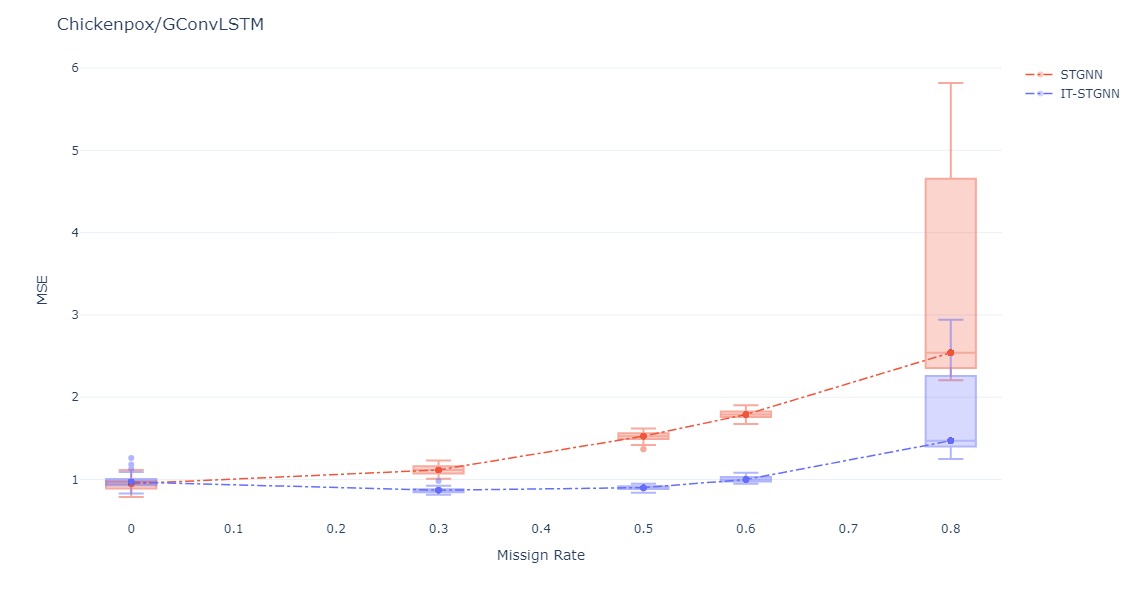

In [55]:
big = df.query("mtype=='rand' or mtype.isna()").query("dataset == 'chickenpox'").query("model == 'GConvLSTM'")\
.sort_values(by='mrate')\
.assign(mrate_jittered = lambda df: np.array(df['mrate'])+np.random.randn(len(df['mrate']))*0.01)
small = big.groupby(["dataset","mrate","method"]).agg({'mse':np.median}).reset_index().rename({'mse':'mse_median'},axis=1)
tidydata = big.merge(small)
#---#
fig = px.scatter(
    tidydata,
    y='mse_median',
    x='mrate',
    opacity=0.3,
    color='method',
    width=600,
    height=600,
    hover_data='mrate'
)
fig.data[0]['mode']='markers+lines'
fig.data[0]['marker']['size'] = 6
fig.data[0]['line']['width'] = 1.5
fig.data[0]['line']['dash'] = 'dashdot'
fig.data[1]['mode']='markers+lines'
fig.data[1]['marker']['size'] = 6
fig.data[1]['line']['width'] =1.5
fig.data[1]['line']['dash'] = 'dashdot'
fig.data[0].marker.color='#EF553B'
fig.data[1].marker.color='#636efa'
box1 = px.box(
    tidydata.query("method=='STGNN'"),
    y='mse',
    x='mrate',
)
box1.data[0]['opacity']=0.5
box1.data[0]['marker']['color']='#EF553B'
box2 = px.box(
    tidydata.query("method=='IT-STGNN'"),
    y='mse',
    x='mrate',
)
box2.data[0]['opacity']=0.5
box2.data[0]['marker']['color']='#636efa'
fig.add_traces(box1.data)
fig.add_traces(box2.data)
fig.data[0]['showlegend'] =True
fig.data[1]['showlegend'] =True
fig.layout['xaxis']['title']['text']='Missign Rate'
fig.layout['yaxis']['title']['text']='MSE'
fig.layout['legend']['title']['text']=""
fig.layout['title']['text']='Chickenpox/GConvLSTM'
fig

In [53]:
fig.data

(Scatter({
     'hovertemplate': 'method=STGNN<br>mrate=%{x}<br>mse_median=%{y}<extra></extra>',
     'legendgroup': 'STGNN',
     'line': {'dash': 'dashdot', 'width': 1.5},
     'marker': {'color': '#EF553B', 'opacity': 0.3, 'size': 6, 'symbol': 'circle'},
     'mode': 'markers+lines',
     'name': 'STGNN',
     'orientation': 'v',
     'showlegend': False,
     'x': array([0. , 0. , 0. , ..., 0.8, 0.8, 0.8]),
     'xaxis': 'x',
     'y': array([0.94850981, 0.94850981, 0.94850981, ..., 2.54059505, 2.54059505,
                 2.54059505]),
     'yaxis': 'y'
 }),
 Scatter({
     'hovertemplate': 'method=IT-STGNN<br>mrate=%{x}<br>mse_median=%{y}<extra></extra>',
     'legendgroup': 'IT-STGNN',
     'line': {'dash': 'dashdot', 'width': 1.5},
     'marker': {'color': '#636efa', 'opacity': 0.3, 'size': 6, 'symbol': 'circle'},
     'mode': 'markers+lines',
     'name': 'IT-STGNN',
     'orientation': 'v',
     'showlegend': False,
     'x': array([0. , 0. , 0. , ..., 0.8, 0.8, 0.8]),
     '

In [49]:
fig.layout.legend

layout.Legend({
    'title': {'text': 'method'}, 'tracegroupgap': 0
})

# 시각화2: MissingRate (부록)

`caption` : 이것은 시험 결과이며, x축은 missing rate를 나타내며, y축은 mse 값에 log를 취한 값을 나타낸다. figure의 행은 model을 나타내고, 열은 dataset을 나타낸다. 

experiment 1의 결과(figure 번호 언급)와 비슷하게 결측값 비율이 커질 수록 mse 값이 증가하지만, classic 이 proposed 보다 더 dramatic하게 go up 한다는 것을 알 수 있다.

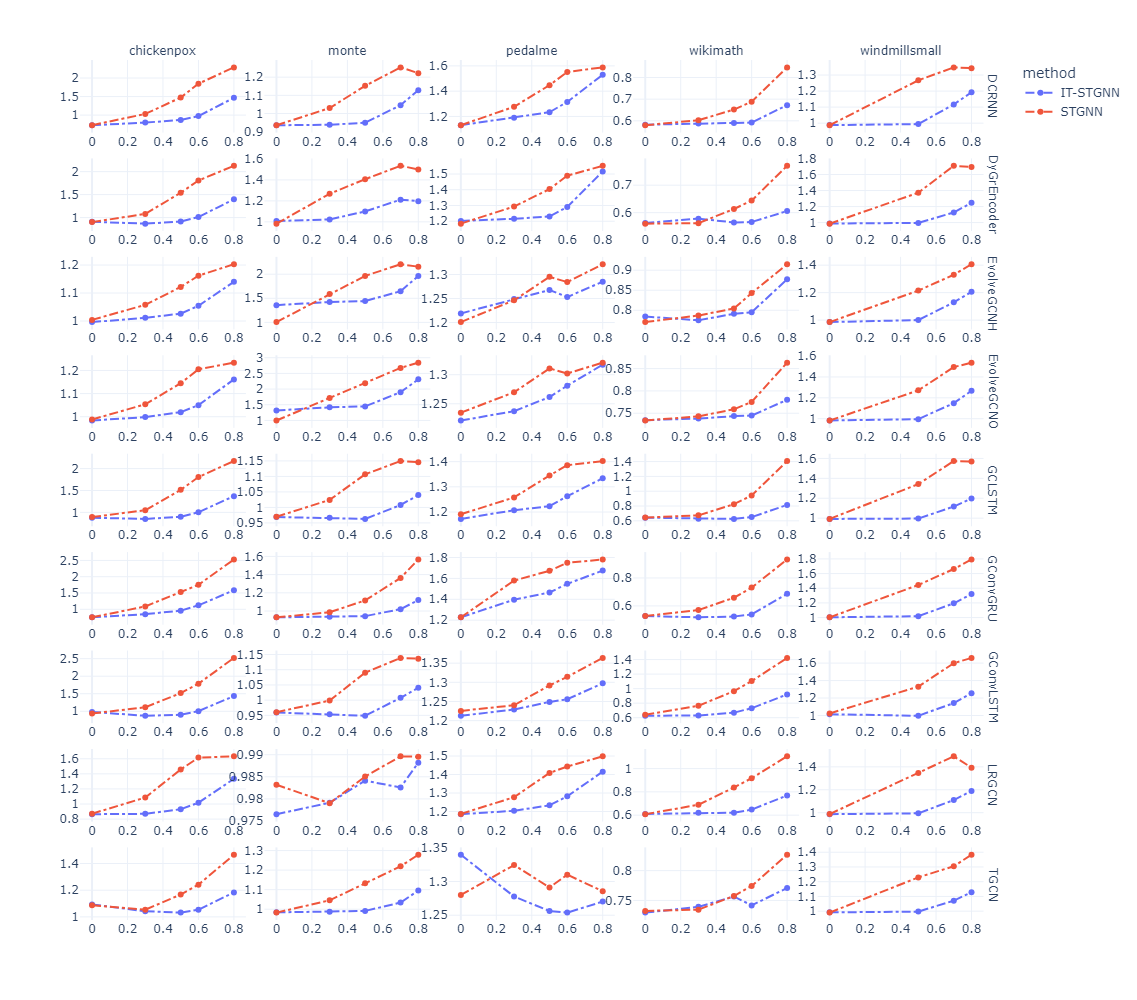

In [42]:
tidydata = df.query("mtype!='block'").query("method!='GNAR'").query("dataset != 'fivenodes' and inter_method not in ('cubic','nearest')")\
.groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()
#---#
fig = px.line(
    tidydata,
    x='mrate',
    y='mse',
    color='method',
    facet_row='model',
    facet_col='dataset',
    width=900,
    height=1000,
    
)
for scatter in fig.data:
    scatter['mode'] = 'lines+markers'
    scatter['line']['dash'] = 'dashdot'
for annotation in fig.layout['annotations']:
    annotation['text'] = annotation['text'].replace('dataset=','')
    annotation['text'] = annotation['text'].replace('model=','')
for k in [k for k in fig.layout if 'xaxis' in k]:
    fig.layout[k]['title']['text'] = None 
for k in [k for k in fig.layout if 'yaxis' in k]:
    fig.layout[k]['title']['text'] = None 
fig.update_yaxes(showticklabels=True,matches=None)
fig.update_xaxes(showticklabels=True,matches=None)

# 시각화3

`caption` : 

## 시각화3-1

> V = 노드의 수, T = 데이터 수로 봤을때, Ratio = T/V를 계산하여 x축에 놓고, classic method와 proposed method 의 mse 차이를 계산하여 y축에 놓았다.

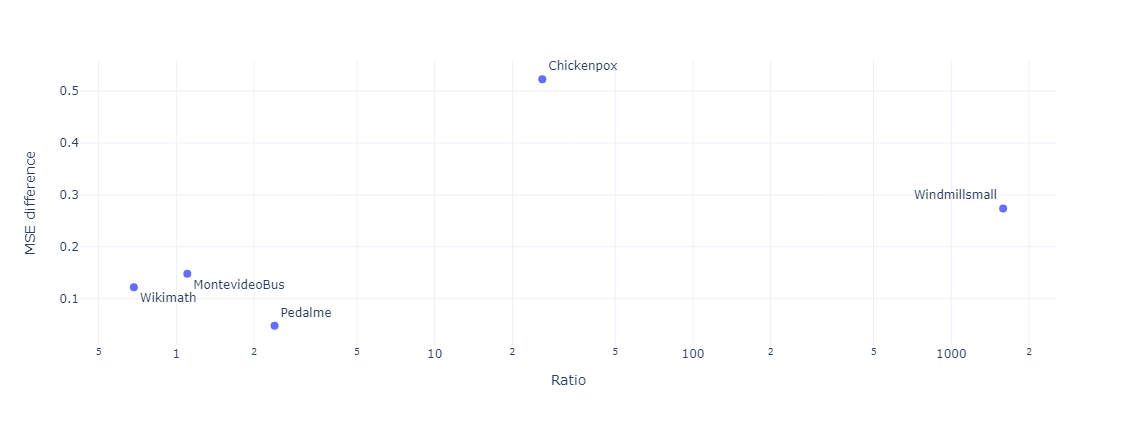

In [26]:
tidydata = df.query('mtype != "block"').query('dataset != "fivenodes"')\
.groupby(["method","dataset","node","time"]).agg({'mse':'mean'}).reset_index()\
.assign(ratio = lambda df: df['time']/df['node'])\
.pivot_table(index=['dataset','ratio'] ,columns=['method'],values='mse')\
.assign(mse_diff = lambda df: df['STGNN']- df['IT-STGNN']).loc[:,'mse_diff']\
.reset_index()
tidydata
fig = px.scatter(
    tidydata,
    x='ratio',
    log_x=True,
    y='mse_diff',
    text='dataset',
    width=625,
    height=425,
    # trendline="ols",
    # trendline_options=dict(log_x=True),
    # trendline_color_override="grey"
)
fig.data[0]['textposition'] = ['top right'] + ['bottom right'] + ['top right'] + ['bottom right'] + ['top left']
fig.data[0]['marker']['size'] = 8
fig.data[0].text = ['Chickenpox', 'MontevideoBus', 'Pedalme', 'Wikimath', 'Windmillsmall']
fig.layout['xaxis']['title']['text']='Ratio'
fig.layout['yaxis']['title']['text']='MSE difference'
fig

## 시각화3-2

> y축은 mse값을 나타내고, missing rate에 상관없이 randomly missing rate을 다르게 한 실험 결과들의 데이터셋 별 모델 별 mse의 순위를 나타내는 figure이다.

In [27]:
def func(x):
    if 'IT-STGCN' in x:
        return 'IT-STGNN'
    elif 'GNAR' in x:
        return 'GNAR'
    else: 
        return 'STGNN'

<ipython-input-28-631074ed5d9e>:3: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



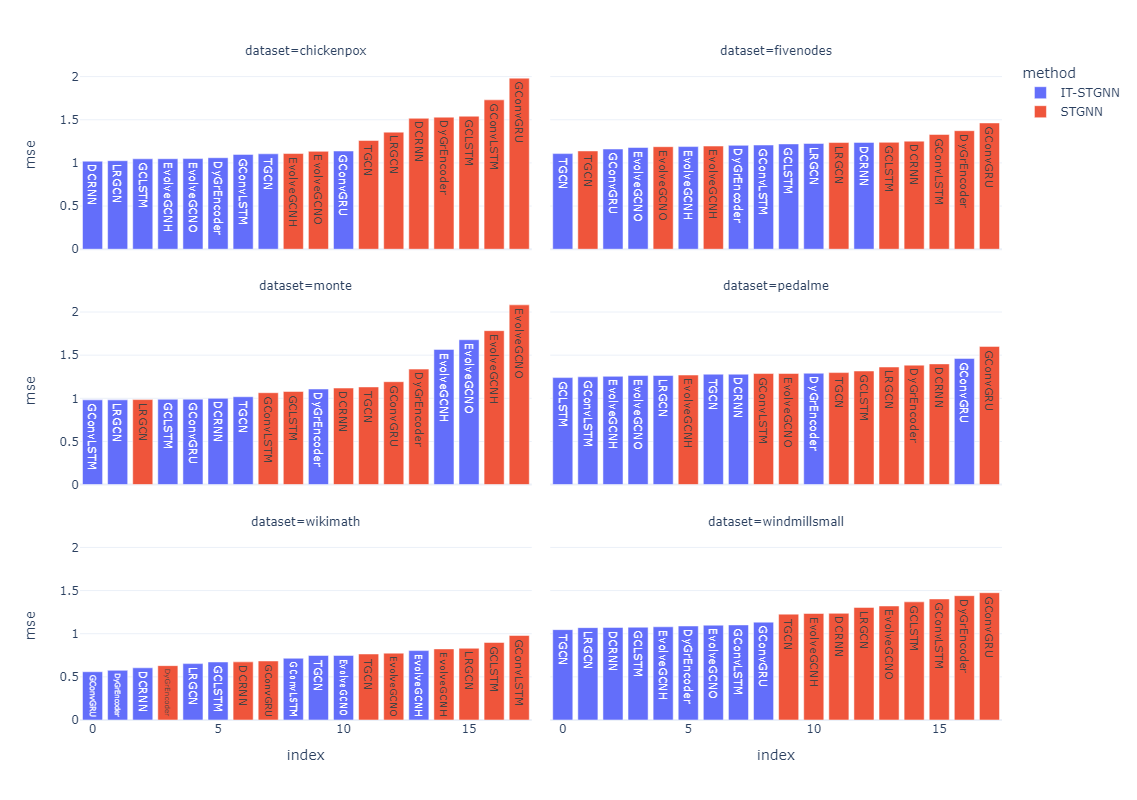

In [28]:
tidydata = df2.query('mtype != "block"').query('method!="GNAR"').groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()\
.pivot_table(index=['model','method'],columns=['dataset'],values='mse').stack().reset_index().rename({0:'mse'},axis=1)
tidydata = pd.concat([df.sort_values('mse').reset_index(drop=True).reset_index() for _,df in tidydata.groupby(["dataset"])])
#---#
fig = px.bar(
    tidydata,
    x='index',
    y='mse',
    color='method',
    facet_col='dataset',
    facet_col_wrap=2,
    text='model',
    height=800
)
fig

# 시각화4

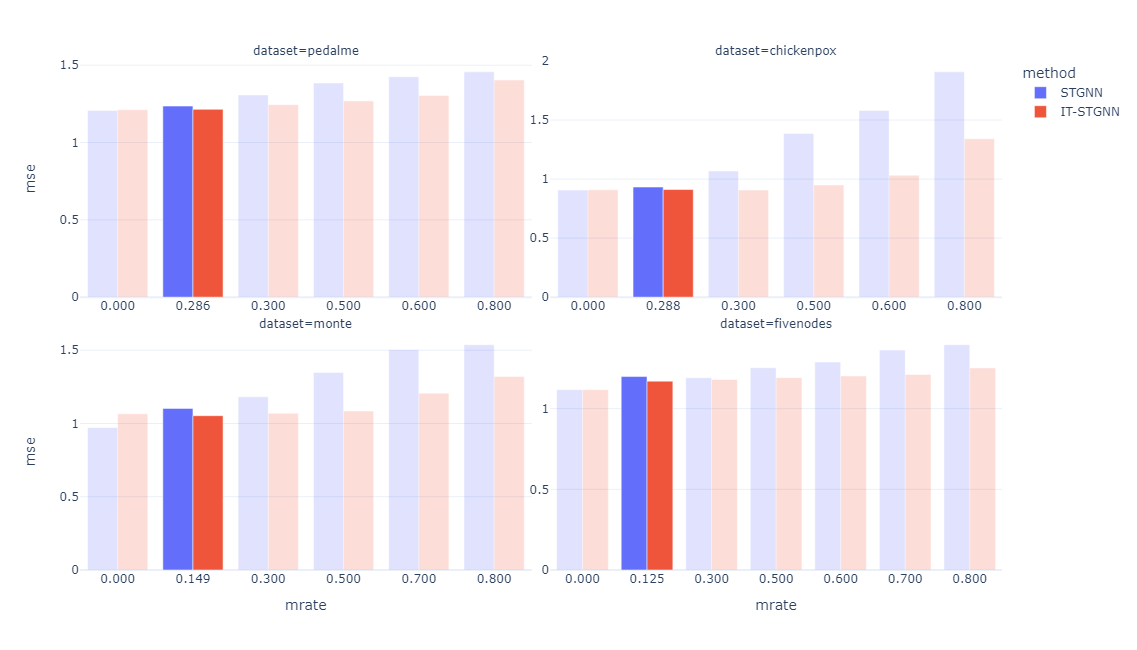

In [29]:
tidydata = df.assign(mtype = df['mtype'].fillna("rand"))\
.query('method != "GNAR" and inter_method not in ["nearest","cubic"]').query('dataset != "windmillsmall"').query('dataset != "wikimath"')\
.groupby(["method","dataset","mtype","mrate"]).agg({'mse':'mean'}).reset_index()\
.sort_values('mrate')\
.assign(mrate = lambda df: df['mrate'].apply(lambda x: f'{x:.3f}'))
#---#
fig = px.bar(
    tidydata,
    x='mrate',
    y='mse',
    color='method',
    facet_col='dataset',
    facet_col_wrap=2,    
    width=850,
    height=650,
    barmode='group',
    hover_data='mtype',
    opacity=0.2
)
fig.update_yaxes(showticklabels=True,matches=None)
fig.update_xaxes(showticklabels=True,matches=None) 
for trace in fig.data:
    trace['marker']['opacity']=[0.2, 1, 0.2, 0.2, 0.2, 0.2, 0.2]
fig

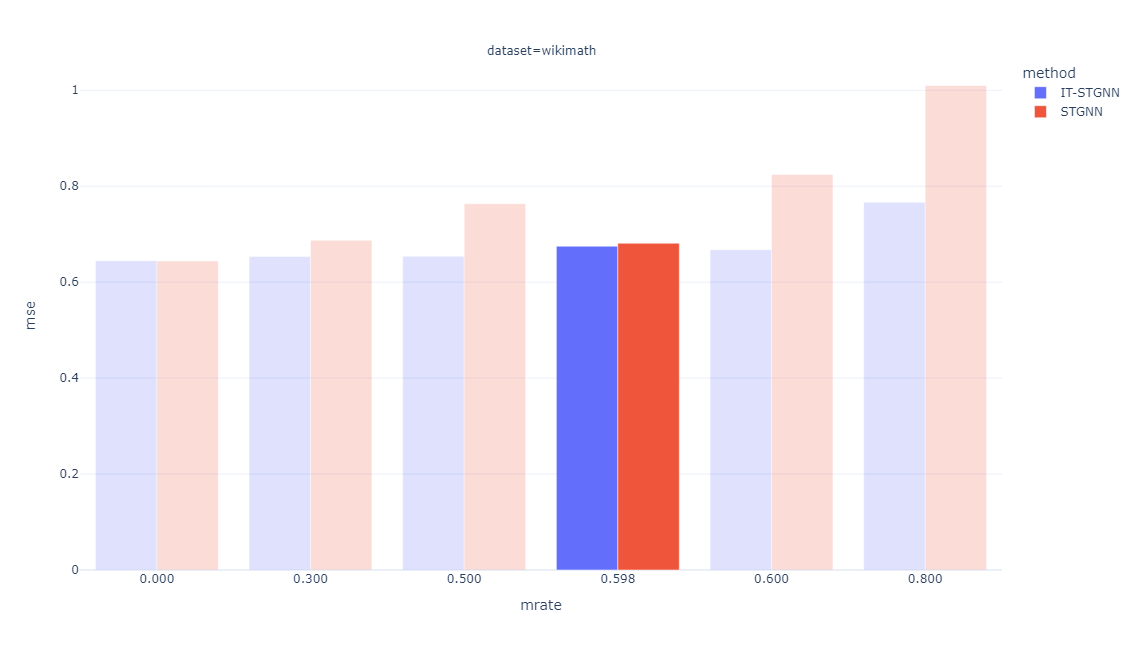

In [30]:
tidydata = df.assign(mtype = df['mtype'].fillna("rand"))\
.query('method != "GNAR" and inter_method not in ["nearest","cubic"]').query('dataset == "wikimath"')\
.groupby(["method","dataset","mtype","mrate"]).agg({'mse':'mean'}).reset_index()\
.sort_values('mrate')\
.assign(mrate = lambda df: df['mrate'].apply(lambda x: f'{x:.3f}'))
#---#
fig = px.bar(
    tidydata,
    x='mrate',
    y='mse',
    color='method',
    facet_col='dataset',
    facet_col_wrap=2,    
    width=850,
    height=650,
    barmode='group',
    hover_data='mtype',
    opacity=0.2
)
fig.update_yaxes(showticklabels=True,matches=None)
fig.update_xaxes(showticklabels=True,matches=None) 
for trace in fig.data:
    trace['marker']['opacity']=[0.2, 0.2, 0.2, 1, 0.2, 0.2, 0.2]
fig

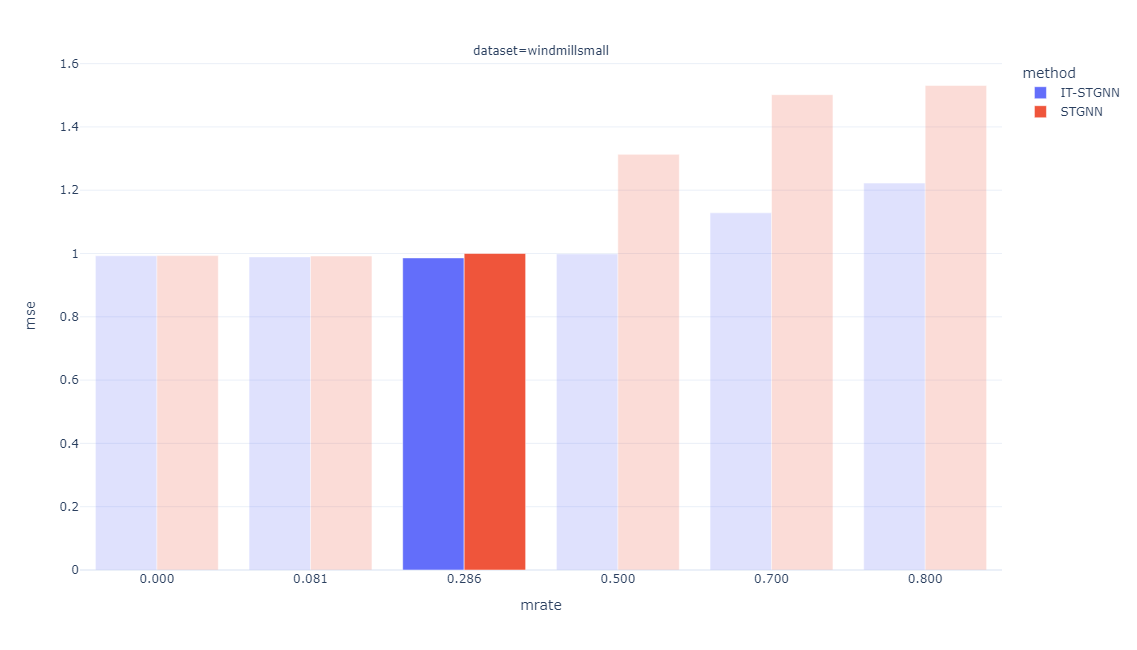

In [31]:
tidydata = df.assign(mtype = df['mtype'].fillna("rand"))\
.query('method != "GNAR" and inter_method not in ["nearest","cubic"]').query('dataset == "windmillsmall"')\
.groupby(["method","dataset","mtype","mrate"]).agg({'mse':'mean'}).reset_index()\
.sort_values('mrate')\
.assign(mrate = lambda df: df['mrate'].apply(lambda x: f'{x:.3f}'))
#---#
fig = px.bar(
    tidydata,
    x='mrate',
    y='mse',
    color='method',
    facet_col='dataset',
    facet_col_wrap=2,    
    width=850,
    height=650,
    barmode='group',
    hover_data='mtype',
    opacity=0.2
)
fig.update_yaxes(showticklabels=True,matches=None)
fig.update_xaxes(showticklabels=True,matches=None) 
for trace in fig.data:
    trace['marker']['opacity']=[0.2, 0.2, 1, 0.2, 0.2, 0.2, 0.2]
fig

# 시각화5(본문)

> dataset은 chickenpox이고, interpolation method를 linear, nearest, cubic으로 주었을때 각각의 결과를 model 구분없이 box plot으로 나타내었다. linear 가 다른 방법들에 비해 error 값이 작게 나온 것을 확인하였기에 우리 paper의 experiment에서도 linear를 중심으로 사용하였다.

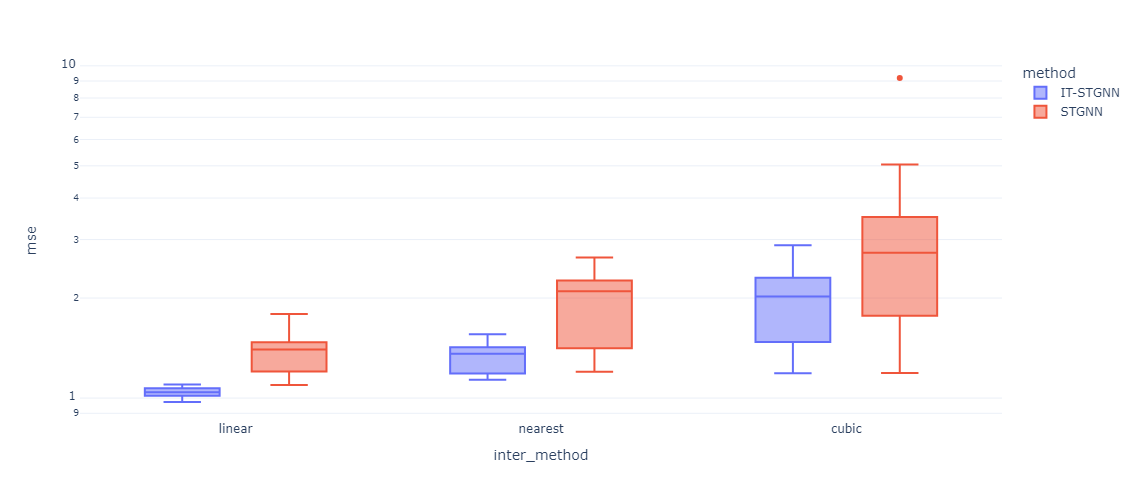

In [32]:
tidydata = pd.concat([df2.query("dataset=='chickenpox'").groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()\
        .pivot_table(index=['model','method'],columns=['dataset'],values='mse').reset_index().rename({'chickenpox':'mse'},axis=1).assign(inter_method='linear'),
           pd.read_csv('../Data/chicken_inter_final.csv').query("inter_method!='cubic'").groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()\
        .pivot_table(index=['model','method'],columns=['dataset'],values='mse').reset_index().rename({'chickenpox':'mse'},axis=1).assign(inter_method='nearest')\
.assign(method = lambda df: df['method'].map({'STGCN':'STGNN','IT-STGCN':'IT-STGNN','GNAR':'GNAR'})),
        pd.read_csv('../Data/chicken_inter_final.csv').query("inter_method=='cubic'").groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()\
        .pivot_table(index=['model','method'],columns=['dataset'],values='mse').reset_index().rename({'chickenpox':'mse'},axis=1).assign(inter_method='cubic')\
.assign(method = lambda df: df['method'].map({'STGCN':'STGNN','IT-STGCN':'IT-STGNN','GNAR':'GNAR'}))
          ])
fig = px.box(tidydata,
            x='inter_method',
            y='mse',
            log_y=True,
            color='method',
            width=1500,
            height=500)
fig